In [1]:
!pip install swig
!pip install "gymnasium[box2d]"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Episode   1 | reward   -13.9 | steps    500/200000 | critic    nan | actor    nan | buffer    500 |   0.2%
Episode   2 | reward   -13.0 | steps   1000/200000 | critic    nan | actor    nan | buffer   1000 |   0.5%
Episode   3 | reward    -7.9 | steps   1500/200000 | critic    nan | actor    nan | buffer   1500 |   0.8%
Episode   4 | reward   -18.4 | steps   2000/200000 | critic    nan | actor    nan | buffer   2000 |   1.0%
Episode   5 | reward   -12.7 | steps   2500/200000 | critic    nan | actor    nan | buffer   2500 |   1.2%
Episode   6 | reward   -15.2 | steps   3000/200000 | critic    nan | actor    nan | buffer   3000 |   1.5%
Episode   7 | reward   -22.7 | steps   3500/200000 | critic    nan | actor    nan | buffer   3500 |   1.8%
Episode   8 | reward   -17.0 | steps   4000/200000 | critic    nan | actor    nan | buffer   4000 |   2.0%
Episode   9 | reward   -13.5 | steps   4500/200000 | critic    nan | actor    nan | buffer   4500 |   2.2%
Episode  10 | reward   -11.0 | steps 

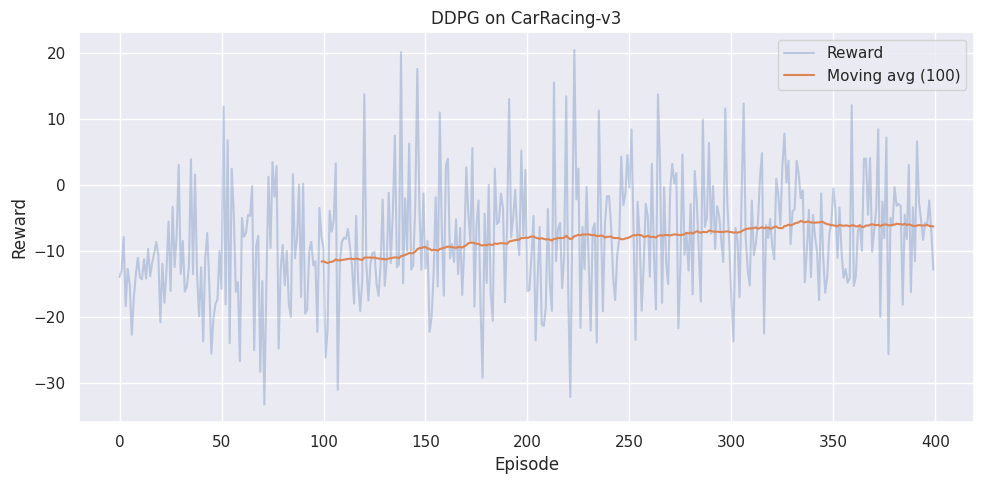

GIF saved


In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import random
from collections import deque
import os
import time
# import gc
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns
sns.set_theme()

from gymnasium.wrappers import (
    GrayscaleObservation,
    ResizeObservation,
    FrameStackObservation,
)


# CONFIG

ENV_NAME = "CarRacing-v3"
SEED = 42

TOTAL_STEPS = 200_000
START_STEPS = 10_000
TRAIN_EVERY = 4
MAX_EPISODE_STEPS = 500

BATCH_SIZE = 128
BUFFER_SIZE = 20_000

GAMMA = 0.99
TAU = 0.005

LR_ACTOR = 1e-3
LR_CRITIC = 1e-3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_DIR = "/content/drive/MyDrive/car_racing_v3_ddpg"
os.makedirs(SAVE_DIR, exist_ok=True)


# SEED

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


# ENV

def make_env(render_mode=None):
    env = gym.make(ENV_NAME, render_mode=render_mode) #, continuous=True)
    env.reset(seed=SEED)
    env = GrayscaleObservation(env)
    env = ResizeObservation(env, (84, 84))
    env = FrameStackObservation(env, stack_size=4)
    return env


# NETWORKS

class Actor(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 4, 84, 84)
            n_flat = self.cnn(dummy).shape[1]

        self.hidden = nn.Sequential(
            nn.Linear(n_flat, 512),
            nn.ReLU(),
        )

        self.mean = nn.Linear(512, 3)
        self.logstd = nn.Parameter(torch.zeros(3))

    def forward(self, x):
        x = self.cnn(x)
        x = self.hidden(x)

        mean = self.mean(x)
        std = self.logstd.exp()

        return mean, std

    def sample_action(self, x):
        mean, std = self.forward(x)
        steering, gas, brake = Normal(mean, std).sample().split(1, dim=1)

        steering = torch.tanh(steering)
        gas = torch.sigmoid(gas)
        brake = torch.sigmoid(brake)
        action = torch.cat([steering, gas, brake], dim=1)

        return action


class Critic(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 4, 84, 84)
            n_flat = self.cnn(dummy).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(n_flat + 3, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x, a):
        x = self.cnn(x)
        x = torch.cat([x, a], dim=1)
        x = self.fc(x)
        return x


# REPLAY BUFFER

class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done


    def __len__(self):
        return len(self.buffer)


# OU NOISE

class OUNoise:
    def __init__(self, size, mu=0.0, theta=0.15,
                 sigma=0.4, sigma_min=0.05, decay=0.999995):
        self.mu = mu
        self.theta = theta

        self.sigma = sigma
        self.sigma_min = sigma_min
        self.decay = decay

        self.size = size
        self.reset()

    def reset(self):
        self.state = np.ones(self.size) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state)
        dx += self.sigma * np.random.randn(self.size)
        self.state += dx
        return self.state

    def step_decay(self):
        self.sigma = max(self.sigma_min, self.sigma * self.decay)


# TRAIN STEP

def train_step():
    states, actions, rewards, next_states, dones = buffer.sample(BATCH_SIZE)

    states_norm = torch.tensor(states, dtype=torch.float32, device=DEVICE) / 255.0
    next_states_norm = torch.tensor(next_states, dtype=torch.float32, device=DEVICE) / 255.0
    actions = torch.tensor(actions, dtype=torch.float32, device=DEVICE)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=DEVICE).unsqueeze(1)
    dones = torch.tensor(dones, dtype=torch.float32, device=DEVICE).unsqueeze(1)

    # critic update
    with torch.no_grad():
        next_actions = actor_target.sample_action(next_states_norm)
        q_target = rewards + GAMMA * (1 - dones) * critic_target(next_states_norm, next_actions)

    q_current = critic(states_norm, actions)
    critic_loss = F.mse_loss(q_current, q_target)

    opt_critic.zero_grad()
    critic_loss.backward()
    opt_critic.step()

    # actor update
    new_actions = actor.sample_action(states_norm)
    actor_loss = -critic(states_norm, new_actions).mean()

    opt_actor.zero_grad()
    actor_loss.backward()
    opt_actor.step()

    # soft updates
    for target_param, param in zip(actor_target.parameters(), actor.parameters()):
        target_param.data.mul_(1 - TAU).add_(TAU * param.data)

    for target_param, param in zip(critic_target.parameters(), critic.parameters()):
        target_param.data.mul_(1 - TAU).add_(TAU * param.data)

    return actor_loss.item(), critic_loss.item()


# INIT

env = make_env()

actor = Actor().to(DEVICE)
critic = Critic().to(DEVICE)

actor_target = Actor().to(DEVICE)
critic_target = Critic().to(DEVICE)

actor_target.load_state_dict(actor.state_dict())
critic_target.load_state_dict(critic.state_dict())

for p in actor_target.parameters():
    p.requires_grad = False
for p in critic_target.parameters():
    p.requires_grad = False

opt_actor = optim.AdamW(actor.parameters(), lr=LR_ACTOR)
opt_critic = optim.AdamW(critic.parameters(), lr=LR_CRITIC)

buffer = ReplayBuffer(BUFFER_SIZE)
ou_noise = OUNoise(3)

state, _ = env.reset()

rewards_all = []
episode_reward = 0
episode_steps = 0
episode = 1

actor_loss = float("nan")
critic_loss = float("nan")

episode_start_time = time.time()
start_time = time.time()


# TRAIN LOOP

for step in range(1, TOTAL_STEPS + 1):

    if step < START_STEPS:
        action = env.action_space.sample()
    else:
        state_norm = torch.tensor(state[None], dtype=torch.float32, device=DEVICE) / 255.0
        with torch.no_grad():
            action = actor.sample_action(state_norm).squeeze(0).cpu().numpy()

        noise = ou_noise.sample()

        action[0] = np.clip(action[0] + noise[0], -1.0, 1.0)  # steering
        action[1] = np.clip(action[1] + noise[1], 0.0, 1.0)   # gas
        action[2] = np.clip(action[2] + noise[2], 0.0, 1.0)   # brake

        ou_noise.step_decay()

    next_state, reward, terminated, truncated, _ = env.step(action)

    done = terminated or truncated

    buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward
    episode_steps += 1

    if step >= START_STEPS and step % TRAIN_EVERY == 0:
        actor_loss, critic_loss = train_step()

    if done or episode_steps >= MAX_EPISODE_STEPS:

        progress = 100 * step / TOTAL_STEPS

        print(
            f"Episode {episode:3d} | "
            f"reward {episode_reward:7.1f} | "
            f"steps {step:6d}/{TOTAL_STEPS} | "
            f"critic {critic_loss:6.3f} | "
            f"actor {actor_loss:6.3f} | "
            f"buffer {len(buffer):6d} | "
            f"{progress:5.1f}%"
        )

        state, _ = env.reset()
        ou_noise.reset()

        rewards_all.append(episode_reward)
        episode_reward = 0
        episode_steps = 0
        episode += 1
        episode_start_time = time.time()

    # if step % 50_000 == 0:
    #     torch.save(actor.state_dict(), f"{SAVE_DIR}/actor_{step}.pt")
    #     torch.save(critic.state_dict(), f"{SAVE_DIR}/critic_{step}.pt")
    #     gc.collect()
    #     torch.cuda.empty_cache()

env.close()

print("=" * 60)
print("Training finished")
print(f"Total steps: {TOTAL_STEPS}")
print(f"Total episodes: {episode - 1}")
print(f"Total time: {(time.time() - start_time)/60:.1f} min")
print("=" * 60)


# PLOT

rewards = np.array(rewards_all)
window = 100

plt.figure(figsize=(10, 5))
plt.plot(rewards, alpha=0.3, label="Reward")

if len(rewards) >= window:
    ma = np.convolve(rewards, np.ones(window)/window, mode="valid")
    plt.plot(np.arange(window-1, len(rewards)), ma, label="Moving avg (100)")

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DDPG on CarRacing-v3")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/rewards.png")
plt.show()


# ANIMATION

env = make_env(render_mode="rgb_array")
state, _ = env.reset()

frames = []
done = False

actor.eval()

while not done:
    img = env.render()
    frames.append(Image.fromarray(img))

    state_norm = torch.tensor(state[None], dtype=torch.float32, device=DEVICE) / 255.0

    with torch.no_grad():
        action = actor.sample_action(state_norm).squeeze(0).cpu().numpy()

    # action[0] = np.clip(action[0] + noise[0], -1.0, 1.0)  # steering
    # action[1] = np.clip(action[1] + noise[1], 0.0, 1.0)   # gas
    # action[2] = np.clip(action[2] + noise[2], 0.0, 1.0)   # brake

    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

frames[0].save(
    f"{SAVE_DIR}/carracing_episode.gif",
    save_all=True,
    append_images=frames[1:],
    duration=40,
    loop=0
)

print("GIF saved")